In [1]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.stattools import adfuller



In [2]:
data = pd.read_csv('BITRE_Fatality-Table 1.csv')
data.head()

/var/folders/3l/xh28kn0j7_7d5hh7fgz188940000gn/T/ipykernel_2926/1511047806.py:1: DtypeWarning: Columns (10,14,15,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('BITRE_Fatality-Table 1.csv')


,Crash ID,State,Month,Year,Dayweek,Time,Crash Type,Bus Involvement,Heavy Rigid Truck Involvement,Articulated Truck Involvement,...,Age,National Remoteness Areas,SA4 Name 2021,National LGA Name 2021,National Road Type,Christmas Period,Easter Period,Age Group,Day of week,Time of day
0,20245021,WA,4,2024,Friday,00:31,Single,No,No,No,...,19,NaN,NaN,NaN,NaN,No,No,17_to_25,Weekday,Night
1,20245021,WA,4,2024,Friday,00:31,Single,No,No,No,...,9,NaN,NaN,NaN,NaN,No,No,0_to_16,Weekday,Night
2,20245021,WA,4,2024,Friday,00:31,Single,No,No,No,...,21,NaN,NaN,NaN,NaN,No,No,17_to_25,Weekday,Night
3,20245021,WA,4,2024,Friday,00:31,Single,No,No,No,...,45,NaN,NaN,NaN,NaN,No,No,40_to_64,Weekday,Night
4,20243023,Qld,4,2024,Friday,01:00,Single,No,No,No,...,24,Outer Regional Australia,Cairns,Cairns,Local Road,No,No,17_to_25,Weekday,Night


19:28:36 - cmdstanpy - INFO - Chain [1] start processing
19:28:36 - cmdstanpy - INFO - Chain [1] done processing


Dickey-Fuller Test Results:
Time of day: Day
ADF Statistic: -3.3153603044049733
p-value: 0.01420567547434362
Critical Value 1%: -3.446599953548936
Critical Value 5%: -2.86870295908671
Critical Value 10%: -2.570585643956714

Time of day: Night
ADF Statistic: -5.340632111323857
p-value: 4.508465746999302e-06
Critical Value 1%: -3.4463221132914486
Critical Value 5%: -2.8685808072418824
Critical Value 10%: -2.570520529031954



19:28:36 - cmdstanpy - INFO - Chain [1] start processing
19:28:37 - cmdstanpy - INFO - Chain [1] done processing


Evaluation Metrics for the Test Period (2023):
Day - MAE: 10.69, MSE: 164.46, MAPE: 15.50%, R2: -0.02
Night - MAE: 5.64, MSE: 45.78, MAPE: 14.00%, R2: 0.20


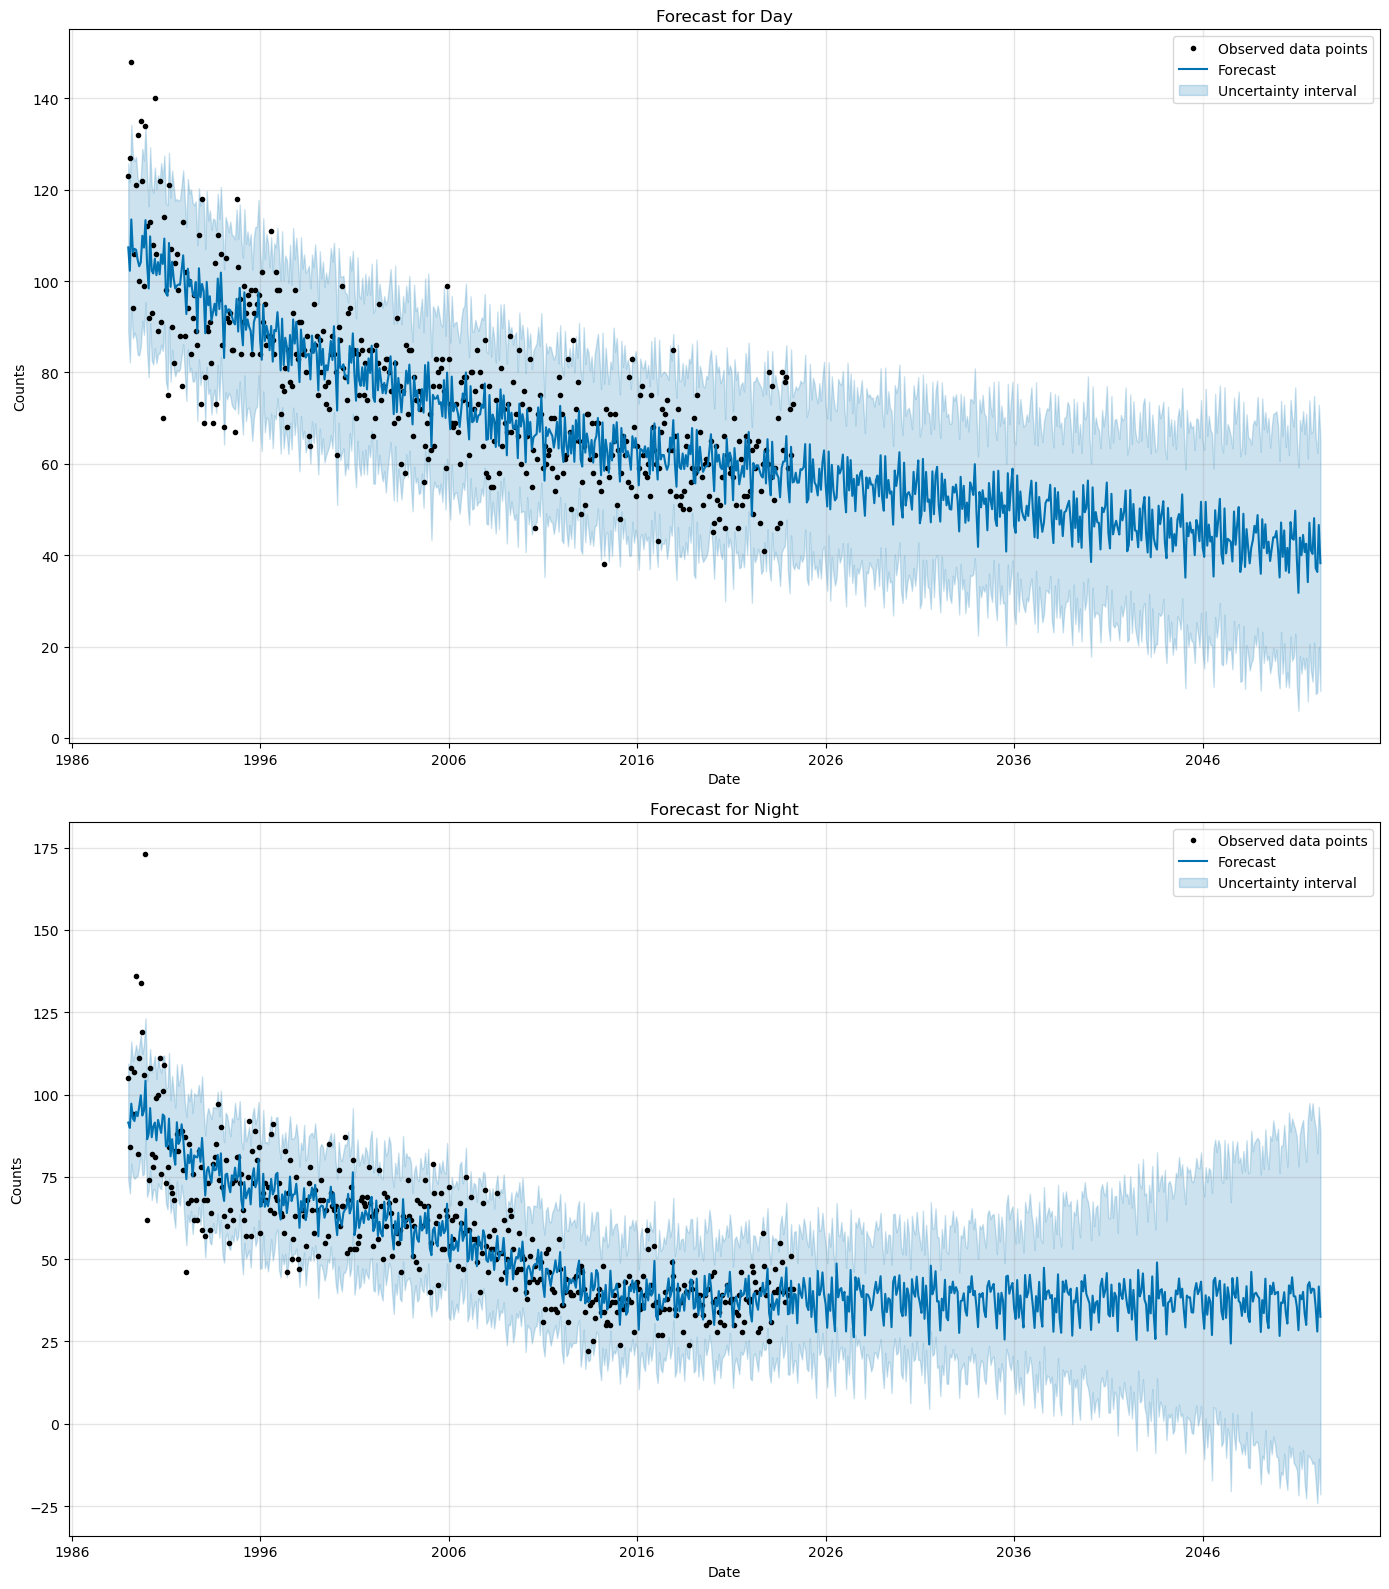


Forecast and Actual Counts for the first three months of 2024:

Time of day: Day
Date       Forecast    Lower Bound    Upper Bound    Actual
2024-01-01     55.52     36.41     75.23  59
2024-02-01     51.56     31.66     71.98  72
2024-03-01     63.72     44.33     85.08  62

Time of day: Night
Date       Forecast    Lower Bound    Upper Bound    Actual
2024-01-01     33.22     14.95     51.83  39
2024-02-01     33.50     14.93     51.14  41
2024-03-01     43.44     24.77     60.70  51


In [8]:

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = pd.Series(y_true), pd.Series(y_pred)
    return (abs((y_true - y_pred) / y_true)).mean() * 100

data['Date'] = pd.to_datetime(data[['Year', 'Month']].assign(DAY=1))

train_data = data[data['Year'] <= 2022]
test_data = data[data['Year'] == 2023]

time_of_day_counts = data.groupby(['Date', 'Time of day']).size().reset_index(name='Counts')

print("Dickey-Fuller Test Results:")
for time in time_of_day_counts['Time of day'].unique():
    time_data = time_of_day_counts[time_of_day_counts['Time of day'] == time]
    result = adfuller(time_data['Counts'])
    print(f"Time of day: {time}")
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    for key, value in result[4].items():
        print(f"Critical Value {key}: {value}")
    print()

time_of_day_models = {}
forecasts = {}
for time in time_of_day_counts['Time of day'].unique():
    time_data = time_of_day_counts[time_of_day_counts['Time of day'] == time]
    time_data = time_data[['Date', 'Counts']].rename(columns={'Date': 'ds', 'Counts': 'y'})
    
    model = Prophet(interval_width=0.95,
                    yearly_seasonality=True,
                    daily_seasonality=True,
                    weekly_seasonality=True,
                    seasonality_mode='additive')
    
    model.fit(time_data)
    time_of_day_models[time] = model
    
    future_dates = model.make_future_dataframe(periods=(2050 - 2022) * 12, freq='M')
    
    forecast = model.predict(future_dates)
    forecasts[time] = forecast

print("Evaluation Metrics for the Test Period (2023):")
for time, forecast in forecasts.items():
    forecast_2023 = forecast[(forecast['ds'] >= '2023-01-01') & (forecast['ds'] <= '2023-12-31')]

    actual_counts_2023 = test_data[test_data['Time of day'] == time].groupby('Date').size().reset_index(name='Counts')
    actual_counts_2023 = actual_counts_2023.rename(columns={'Date': 'ds', 'Counts': 'y'})
    
    forecast_2023 = forecast_2023.set_index('ds').loc[actual_counts_2023['ds']].reset_index()
    
    mae = mean_absolute_error(actual_counts_2023['y'], forecast_2023['yhat'])
    mse = mean_squared_error(actual_counts_2023['y'], forecast_2023['yhat'])
    mape = mean_absolute_percentage_error(actual_counts_2023['y'], forecast_2023['yhat'])
    r2 = r2_score(actual_counts_2023['y'], forecast_2023['yhat'])
    
    print(f"{time} - MAE: {mae:.2f}, MSE: {mse:.2f}, MAPE: {mape:.2f}%, R2: {r2:.2f}")
    
fig, axes = plt.subplots(nrows=len(forecasts), ncols=1, figsize=(14, 8*len(forecasts)))

for ax, (time, forecast) in zip(axes, forecasts.items()):
    model = time_of_day_models[time]
    model.plot(forecast, ax=ax, xlabel='Date', ylabel='Counts')
    
    # Plot training data
    #train_time_data = time_of_day_counts[time_of_day_counts['Time of day'] == time]
    #ax.scatter(train_time_data['Date'], train_time_data['Counts'], color='blue', s=10, label='Training Data')
    
    # Plot test data
   # test_time_data = test_data[test_data['Time of day'] == time].groupby('Date').size().reset_index(name='Counts')
    #ax.scatter(test_time_data['Date'], test_time_data['Counts'], color='red', s=10, label='Test Data')
    
    ax.legend()
    ax.set_title(f'Forecast for {time}')

plt.tight_layout()
plt.show()

# Save the plot
#fig.savefig('time_of_day_forecast.png')

print("\nForecast and Actual Counts for the first three months of 2024:")
for time, forecast in forecasts.items():
    forecast_2024 = forecast[(forecast['ds'] >= '2024-01-01') & (forecast['ds'] <= '2024-03-31')]
    
    actual_counts_2024 = data[(data['Time of day'] == time) & (data['Date'] >= '2024-01-01') & (data['Date'] <= '2024-03-31')]
    actual_counts_2024 = actual_counts_2024.groupby('Date').size().reset_index(name='Counts')
    actual_counts_2024 = actual_counts_2024.rename(columns={'Date': 'ds', 'Counts': 'y'})
    
    # Print the results
    print(f"\nTime of day: {time}")
    print("Date       Forecast    Lower Bound    Upper Bound    Actual")
    for date in forecast_2024['ds']:
        forecast_row = forecast_2024[forecast_2024['ds'] == date]
        forecast_count = forecast_row['yhat'].values[0]
        lower_bound = forecast_row['yhat_lower'].values[0]
        upper_bound = forecast_row['yhat_upper'].values[0]
        actual_count = actual_counts_2024[actual_counts_2024['ds'] == date]['y'].values[0] if not actual_counts_2024[actual_counts_2024['ds'] == date].empty else 'N/A'
        print(f"{date.strftime('%Y-%m-%d')}  {forecast_count:8.2f}  {lower_bound:8.2f}  {upper_bound:8.2f}  {actual_count}")


23:49:30 - cmdstanpy - INFO - Chain [1] start processing
23:49:30 - cmdstanpy - INFO - Chain [1] done processing
23:49:30 - cmdstanpy - INFO - Chain [1] start processing
23:49:30 - cmdstanpy - INFO - Chain [1] done processing


Evaluation Metrics for the Test Period (2023) - Time of day:
Day - MAE: 10.69, MSE: 164.46, MAPE: 15.50%, R2: -0.02
Forecast vs Actual for first three months of 2024 for Day:
            ds       yhat  yhat_lower  yhat_upper
420 2024-01-01  55.518522   36.123752   75.127685
421 2024-02-01  51.564729   32.419548   71.299847
422 2024-03-01  63.717801   44.752432   81.513318
        Date  Counts
0 2024-01-01      59
1 2024-02-01      72
2 2024-03-01      62

Forecast for Day in 2030:
            ds       yhat  yhat_lower  yhat_upper
493 2030-01-31  48.202014   30.130839   68.866229
494 2030-02-28  60.237669   40.355700   79.748873
495 2030-03-31  50.870047   33.307301   69.760309
496 2030-04-30  53.361645   35.316815   72.569783
497 2030-05-31  53.806848   33.001785   72.146417
498 2030-06-30  52.829060   34.526218   73.505337
499 2030-07-31  49.958190   31.187281   69.051545
500 2030-08-31  58.242043   37.992269   76.147273
501 2030-09-30  53.354572   33.344501   72.924506
502 2030-10-31

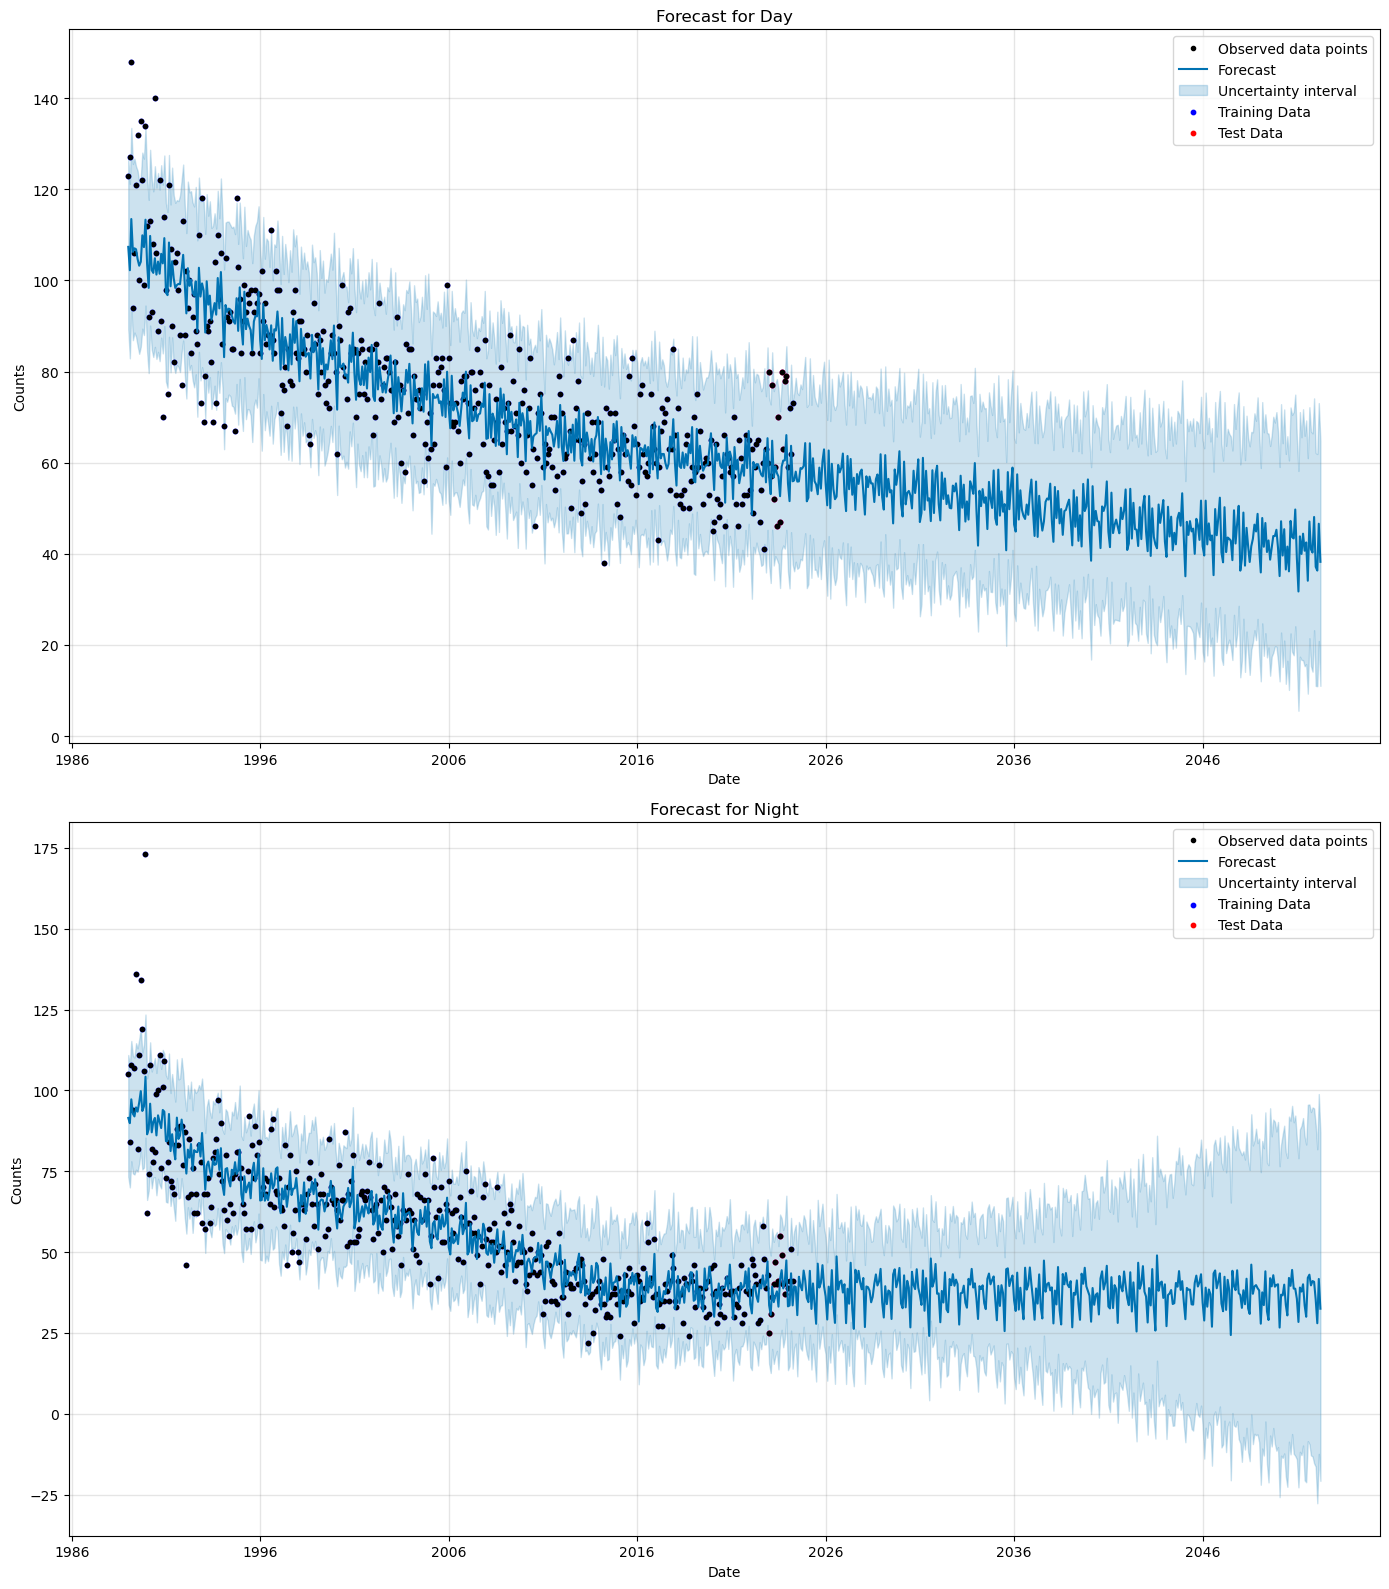

Dickey-Fuller Test Results:

Time of day: Day
ADF Statistic: -3.3153603044049733
p-value: 0.01420567547434362
Critical Value 1%: -3.446599953548936
Critical Value 5%: -2.86870295908671
Critical Value 10%: -2.570585643956714

Time of day: Night
ADF Statistic: -5.340632111323857
p-value: 4.508465746999302e-06
Critical Value 1%: -3.4463221132914486
Critical Value 5%: -2.8685808072418824
Critical Value 10%: -2.570520529031954


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.stattools import adfuller

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = pd.Series(y_true), pd.Series(y_pred)
    return (abs((y_true - y_pred) / y_true)).mean() * 100

# Convert the 'Year' and 'Month' columns to a single datetime column
data['Date'] = pd.to_datetime(data[['Year', 'Month']].assign(DAY=1))

# Filter data up to 2022 for training and 2023 for testing
train_data = data[data['Year'] <= 2022]
test_data = data[data['Year'] == 2023]

# Aggregate the number of occurrences of each feature per month for training data
def aggregate_counts(data, feature):
    return data.groupby(['Date', feature]).size().reset_index(name='Counts')

# Prepare the data for Prophet and forecast
def forecast_feature(data, feature):
    counts = aggregate_counts(data, feature)
    
    models = {}
    forecasts = {}
    for value in counts[feature].unique():
        value_data = counts[counts[feature] == value]
        value_data = value_data[['Date', 'Counts']].rename(columns={'Date': 'ds', 'Counts': 'y'})

        # Initialize and fit the Prophet model
        model = Prophet(interval_width=0.95,
                        yearly_seasonality=True,
                        daily_seasonality=True,
                        weekly_seasonality=True,
                        seasonality_mode='additive')
        model.fit(value_data)
        models[value] = model

        # Create a dataframe for future dates including 2023 (test period) and beyond
        future_dates = model.make_future_dataframe(periods=(2050 - 2022) * 12, freq='M')

        # Predict future values
        forecast = model.predict(future_dates)
        forecasts[value] = forecast
    
    return models, forecasts

# Forecast for a specific feature
feature = 'Time of day'  # Change this to the desired feature
time_of_day_models, forecasts = forecast_feature(data, feature)

# Calculate and print evaluation metrics for the test period (2023)
print(f"Evaluation Metrics for the Test Period (2023) - {feature}:")
for value, forecast in forecasts.items():
    # Filter forecast for 2023
    forecast_2023 = forecast[(forecast['ds'] >= '2023-01-01') & (forecast['ds'] <= '2023-12-31')]

    # Filter actual counts for 2023
    actual_counts_2023 = test_data[test_data[feature] == value].groupby('Date').size().reset_index(name='Counts')
    actual_counts_2023 = actual_counts_2023.rename(columns={'Date': 'ds', 'Counts': 'y'})

    # Ensure the forecast and actual data are aligned
    forecast_2023 = forecast_2023.set_index('ds').loc[actual_counts_2023['ds']].reset_index()

    # Calculate evaluation metrics
    mae = mean_absolute_error(actual_counts_2023['y'], forecast_2023['yhat'])
    mse = mean_squared_error(actual_counts_2023['y'], forecast_2023['yhat'])
    mape = mean_absolute_percentage_error(actual_counts_2023['y'], forecast_2023['yhat'])
    r2 = r2_score(actual_counts_2023['y'], forecast_2023['yhat'])

    print(f"{value} - MAE: {mae:.2f}, MSE: {mse:.2f}, MAPE: {mape:.2f}%, R2: {r2:.2f}")
    print(f"Forecast vs Actual for first three months of 2024 for {value}:")
    future_2024 = forecast[(forecast['ds'] >= '2024-01-01') & (forecast['ds'] <= '2024-03-31')]
    print(future_2024[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])

    # Filter actual counts for first three months of 2024
    actual_counts_2024 = data[(data['Date'] >= '2024-01-01') & (data['Date'] <= '2024-03-31') & (data[feature] == value)]
    actual_counts_2024 = actual_counts_2024.groupby('Date').size().reset_index(name='Counts')
    print(actual_counts_2024)
    print()

    # Print forecast for 2030, 2040, and 2050
    future_2030 = forecast[(forecast['ds'] >= '2030-01-01') & (forecast['ds'] <= '2030-12-31')]
    future_2040 = forecast[(forecast['ds'] >= '2040-01-01') & (forecast['ds'] <= '2040-12-31')]
    future_2050 = forecast[(forecast['ds'] >= '2050-01-01') & (forecast['ds'] <= '2050-12-31')]
    
    print(f"Forecast for {value} in 2030:")
    print(future_2030[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])
    print()
    
    print(f"Forecast for {value} in 2040:")
    print(future_2040[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])
    print()
    
    print(f"Forecast for {value} in 2050:")
    print(future_2050[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])
    print()

# Plot the forecasts
fig, axes = plt.subplots(nrows=len(forecasts), ncols=1, figsize=(14, 8*len(forecasts)))

for ax, (value, forecast) in zip(axes, forecasts.items()):
    model = time_of_day_models[value]
    model.plot(forecast, ax=ax, xlabel='Date', ylabel='Counts')
    
    # Plot training data
    train_time_data = data[data[feature] == value].groupby('Date').size().reset_index(name='Counts')
    ax.scatter(train_time_data['Date'], train_time_data['Counts'], color='blue', s=10, label='Training Data')
    
    # Plot test data
    test_time_data = test_data[test_data[feature] == value].groupby('Date').size().reset_index(name='Counts')
    ax.scatter(test_time_data['Date'], test_time_data['Counts'], color='red', s=10, label='Test Data')
    
    ax.legend()
    ax.set_title(f'Forecast for {value}')

# Show the plot
plt.tight_layout()
plt.show()

# Save the plot

# Perform Dickey-Fuller Test
print("Dickey-Fuller Test Results:")
for value, forecast in forecasts.items():
    time_data = data[data[feature] == value].groupby('Date').size().reset_index(name='Counts')
    adf_result = adfuller(time_data['Counts'])
    print(f"\nTime of day: {value}")
    print(f"ADF Statistic: {adf_result[0]}")
    print(f"p-value: {adf_result[1]}")
    for key, value in adf_result[4].items():
        print(f"Critical Value {key}: {value}")


Optimized Code

23:57:41 - cmdstanpy - INFO - Chain [1] start processing
23:57:41 - cmdstanpy - INFO - Chain [1] done processing
23:57:41 - cmdstanpy - INFO - Chain [1] start processing
23:57:41 - cmdstanpy - INFO - Chain [1] done processing


Evaluation Metrics for the Test Period (2023) - Time of day:
Day - MAE: 10.69, MSE: 164.46, MAPE: 15.50%, R2: -0.02
Forecast vs Actual for first three months of 2024 for Day:
            ds       yhat  yhat_lower  yhat_upper
420 2024-01-01  55.518522   35.859745   74.859033
421 2024-02-01  51.564729   32.257138   71.690687
422 2024-03-01  63.717801   44.276013   82.357220
        Date  Counts
0 2024-01-01      59
1 2024-02-01      72
2 2024-03-01      62

Forecast for Day in 2030:
            ds       yhat  yhat_lower  yhat_upper
493 2030-01-31  48.202014   28.454530   67.453815
494 2030-02-28  60.237669   41.398836   80.077886
495 2030-03-31  50.870047   31.481862   71.809843
496 2030-04-30  53.361645   35.127346   72.031151
497 2030-05-31  53.806848   34.817884   72.840479
498 2030-06-30  52.829060   32.242801   73.398416
499 2030-07-31  49.958190   30.698629   70.687660
500 2030-08-31  58.242043   39.069571   77.646912
501 2030-09-30  53.354572   35.182916   72.447397
502 2030-10-31

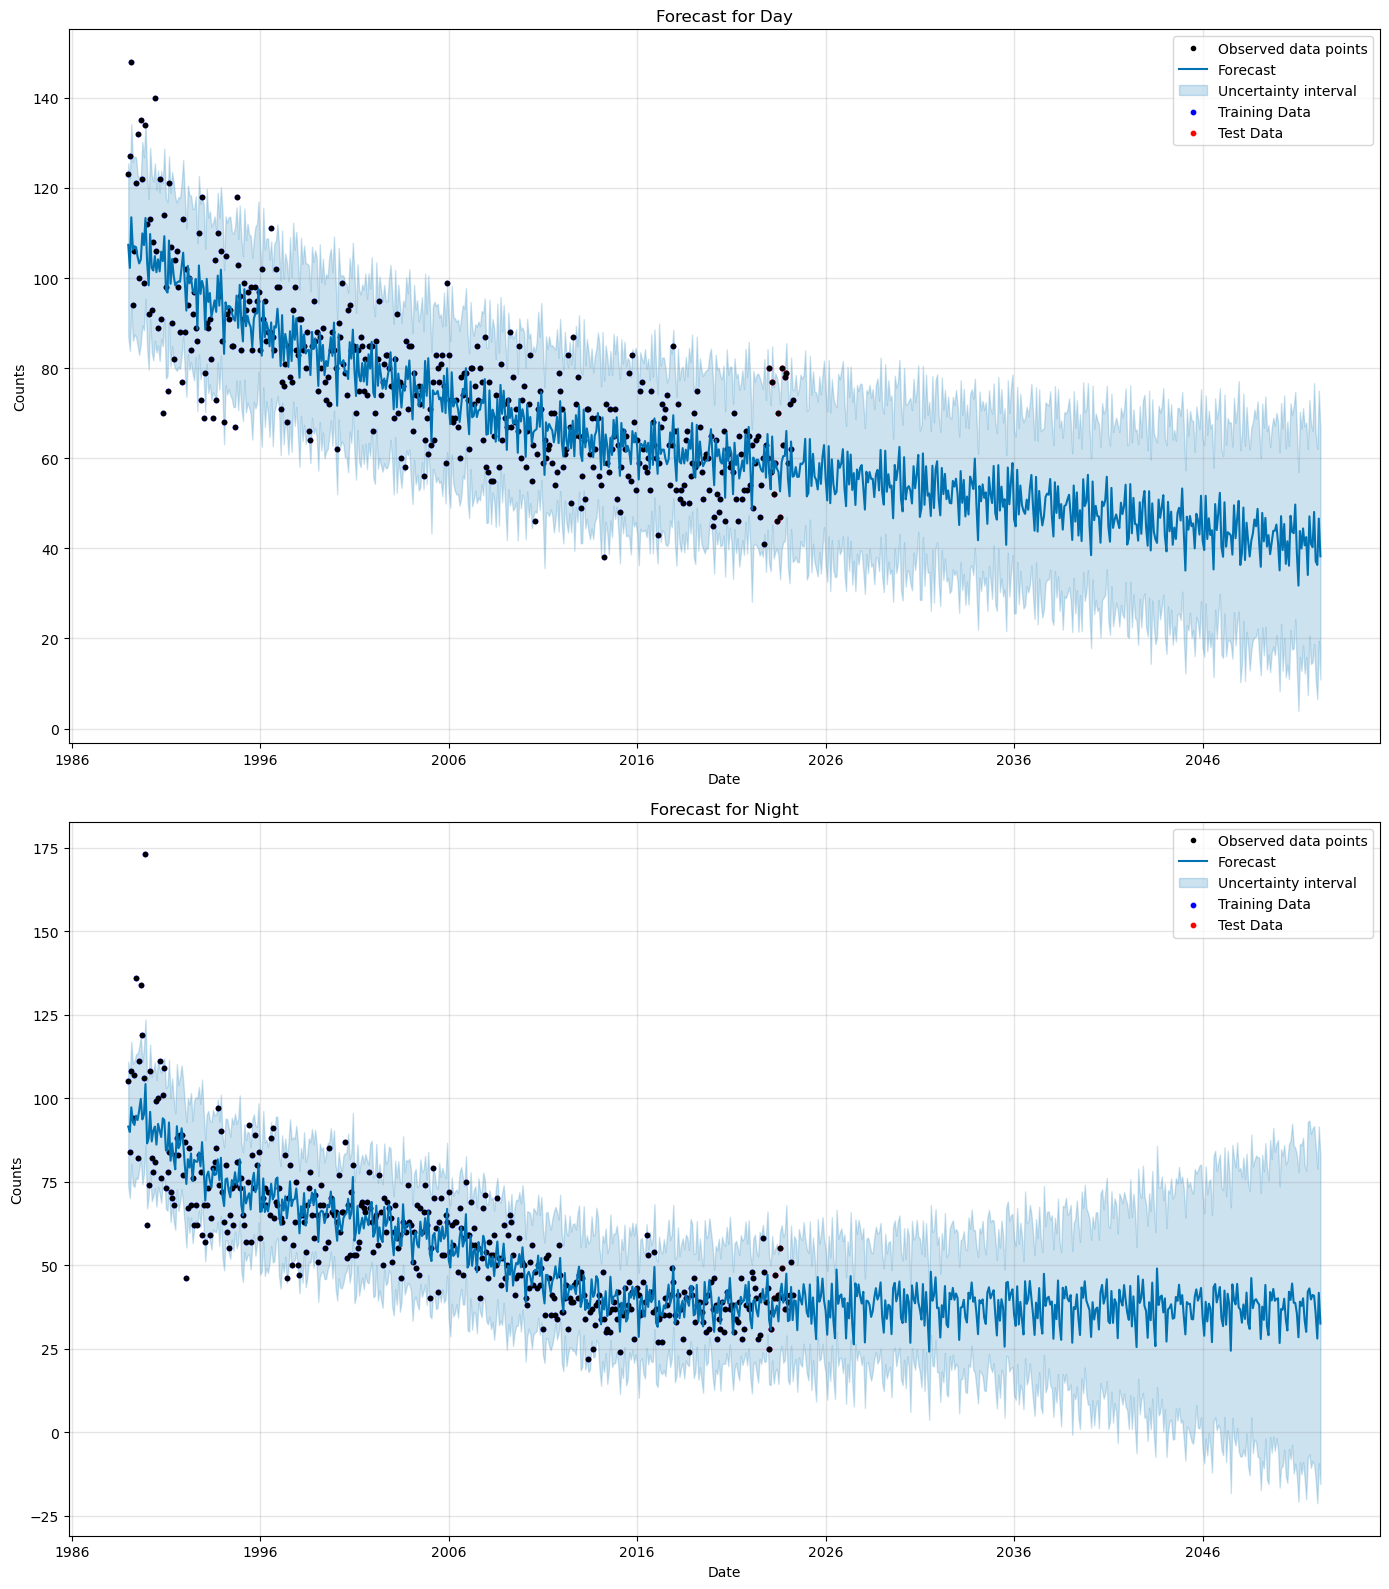

Dickey-Fuller Test Results:

Time of day: Day
ADF Statistic: -3.3153603044049733
p-value: 0.01420567547434362
Critical Value 1%: -3.446599953548936
Critical Value 5%: -2.86870295908671
Critical Value 10%: -2.570585643956714

Time of day: Night
ADF Statistic: -5.340632111323857
p-value: 4.508465746999302e-06
Critical Value 1%: -3.4463221132914486
Critical Value 5%: -2.8685808072418824
Critical Value 10%: -2.570520529031954

Actual Counts per Year (2013-2023):
Year 2013: 1186 counts
Year 2014: 1150 counts
Year 2015: 1206 counts
Year 2016: 1294 counts
Year 2017: 1223 counts
Year 2018: 1135 counts
Year 2019: 1186 counts
Year 2020: 1097 counts
Year 2021: 1130 counts
Year 2022: 1180 counts
Year 2023: 1270 counts


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.stattools import adfuller

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = pd.Series(y_true), pd.Series(y_pred)
    return (abs((y_true - y_pred) / y_true)).mean() * 100

# Convert the 'Year' and 'Month' columns to a single datetime column
data['Date'] = pd.to_datetime(data[['Year', 'Month']].assign(DAY=1))

# Filter data up to 2022 for training and 2023 for testing
train_data = data[data['Year'] <= 2022]
test_data = data[data['Year'] == 2023]

# Aggregate the number of occurrences of each feature per month for training data
def aggregate_counts(data, feature):
    return data.groupby(['Date', feature]).size().reset_index(name='Counts')

# Prepare the data for Prophet and forecast
def forecast_feature(data, feature):
    counts = aggregate_counts(data, feature)
    
    models = {}
    forecasts = {}
    for value in counts[feature].unique():
        value_data = counts[counts[feature] == value]
        value_data = value_data[['Date', 'Counts']].rename(columns={'Date': 'ds', 'Counts': 'y'})

        # Initialize and fit the Prophet model
        model = Prophet(interval_width=0.95,
                        yearly_seasonality=True,
                        daily_seasonality=True,
                        weekly_seasonality=True,
                        seasonality_mode='additive')
        model.fit(value_data)
        models[value] = model

        # Create a dataframe for future dates including 2023 (test period) and beyond
        future_dates = model.make_future_dataframe(periods=(2050 - 2022) * 12, freq='M')

        # Predict future values
        forecast = model.predict(future_dates)
        forecasts[value] = forecast
    
    return models, forecasts

# Forecast for a specific feature
feature = 'Time of day'  # Change this to the desired feature
time_of_day_models, forecasts = forecast_feature(data, feature)

# Calculate and print evaluation metrics for the test period (2023)
print(f"Evaluation Metrics for the Test Period (2023) - {feature}:")
for value, forecast in forecasts.items():
    # Filter forecast for 2023
    forecast_2023 = forecast[(forecast['ds'] >= '2023-01-01') & (forecast['ds'] <= '2023-12-31')]

    # Filter actual counts for 2023
    actual_counts_2023 = test_data[test_data[feature] == value].groupby('Date').size().reset_index(name='Counts')
    actual_counts_2023 = actual_counts_2023.rename(columns={'Date': 'ds', 'Counts': 'y'})

    # Ensure the forecast and actual data are aligned
    forecast_2023 = forecast_2023.set_index('ds').loc[actual_counts_2023['ds']].reset_index()

    # Calculate evaluation metrics
    mae = mean_absolute_error(actual_counts_2023['y'], forecast_2023['yhat'])
    mse = mean_squared_error(actual_counts_2023['y'], forecast_2023['yhat'])
    mape = mean_absolute_percentage_error(actual_counts_2023['y'], forecast_2023['yhat'])
    r2 = r2_score(actual_counts_2023['y'], forecast_2023['yhat'])

    print(f"{value} - MAE: {mae:.2f}, MSE: {mse:.2f}, MAPE: {mape:.2f}%, R2: {r2:.2f}")
    print(f"Forecast vs Actual for first three months of 2024 for {value}:")
    future_2024 = forecast[(forecast['ds'] >= '2024-01-01') & (forecast['ds'] <= '2024-03-31')]
    print(future_2024[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])

    # Filter actual counts for first three months of 2024
    actual_counts_2024 = data[(data['Date'] >= '2024-01-01') & (data['Date'] <= '2024-03-31') & (data[feature] == value)]
    actual_counts_2024 = actual_counts_2024.groupby('Date').size().reset_index(name='Counts')
    print(actual_counts_2024)
    print()

    # Print forecast for 2030, 2040, and 2050
    future_2030 = forecast[(forecast['ds'] >= '2030-01-01') & (forecast['ds'] <= '2030-12-31')]
    future_2040 = forecast[(forecast['ds'] >= '2040-01-01') & (forecast['ds'] <= '2040-12-31')]
    future_2050 = forecast[(forecast['ds'] >= '2050-01-01') & (forecast['ds'] <= '2050-12-31')]
    
    print(f"Forecast for {value} in 2030:")
    print(future_2030[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])
    print()
    
    print(f"Forecast for {value} in 2040:")
    print(future_2040[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])
    print()
    
    print(f"Forecast for {value} in 2050:")
    print(future_2050[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])
    print()

# Plot the forecasts
fig, axes = plt.subplots(nrows=len(forecasts), ncols=1, figsize=(14, 8*len(forecasts)))

for ax, (value, forecast) in zip(axes, forecasts.items()):
    model = time_of_day_models[value]
    model.plot(forecast, ax=ax, xlabel='Date', ylabel='Counts')
    
    # Plot training data
    train_time_data = data[data[feature] == value].groupby('Date').size().reset_index(name='Counts')
    ax.scatter(train_time_data['Date'], train_time_data['Counts'], color='blue', s=10, label='Training Data')
    
    # Plot test data
    test_time_data = test_data[test_data[feature] == value].groupby('Date').size().reset_index(name='Counts')
    ax.scatter(test_time_data['Date'], test_time_data['Counts'], color='red', s=10, label='Test Data')
    
    ax.legend()
    ax.set_title(f'Forecast for {value}')

# Show the plot
plt.tight_layout()
plt.show()

# Save the plot

# Perform Dickey-Fuller Test
print("Dickey-Fuller Test Results:")
for value, forecast in forecasts.items():
    time_data = data[data[feature] == value].groupby('Date').size().reset_index(name='Counts')
    adf_result = adfuller(time_data['Counts'])
    print(f"\nTime of day: {value}")
    print(f"ADF Statistic: {adf_result[0]}")
    print(f"p-value: {adf_result[1]}")
    for key, value in adf_result[4].items():
        print(f"Critical Value {key}: {value}")

# Print actual counts for each year from 2013 to 2023
print("\nActual Counts per Year (2013-2023):")
for year in range(2013, 2024):
    year_counts = data[data['Year'] == year].groupby('Year').size().reset_index(name='Counts')
    print(f"Year {year}: {year_counts['Counts'].sum()} counts")
